# Exercises week 1

Lorenzo Buriola - Filippo Conforto - Lorenzo Domenichetti

# Ex 1

We define the needed python functions returning the gradient and the actual function f(x,y) itself. We also plot the function in a choosen interval for $x$ and $y$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [5]:
def func(X, b = 20, q = 0.1, w = 10):
    return b*(1-np.exp(-0.5*w*(X[0]**2+X[1]**2))) + 0.5*q*(-X[0]**3 + X[1])**2

def gradx(X, b = 20, q = 0.1, w = 10):
    return b*np.exp(-0.5*w*(X[0]**2+X[1]**2)) *w*X[0] - 3*q*X[0]**2*(-X[0]**3 + X[1])

def grady(X, b = 20, q = 0.1, w = 10):
    return b*np.exp(-0.5*w*(X[0]**2 + X[1]**2))*w*X[1] + q*(-X[0]**3 + X[1])

def grad(X):
    return [gradx(X), grady(X)]

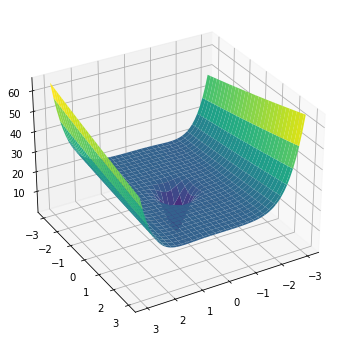

In [3]:
xplot = np.linspace(-3, 3, 60)
yplot = np.linspace(-3, 3, 60)


Xplot = np.meshgrid(xplot,yplot)
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(projection = '3d')

ax.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'viridis')
ax.view_init(30,60)
plt.show()

In [4]:
x = np.linspace(-3, 3, 15)
y = np.linspace(-3, 3, 15)

X = np.meshgrid(x,y)

Let us now define the "gradient descent" methods as can be found in the reference notebook (GD, GD with momentum, NAG, RMS_prop and ADAM)

In [1]:
# Vanilla GD
def gd(grad, init, n_epochs=1000, eta=10**-4, noise_strength=0, timing=False):
    start = time.time()
    #This is a simple optimizer
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,3])
    param_traj[0,]=[init[0], init[1], 0]
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=[params[0], params[1], time.time()-start]
    if timing == False:
        return param_traj[:,:2]
    return param_traj

# Momentum GD
def gd_with_mom(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

# NAG
def NAG(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

#RMS_PROP
def rms_prop(grad, init, n_epochs=5000, eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init#Import relevant packages
    grad_sq=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v=eta*np.divide(g,np.sqrt(grad_sq+epsilon))
        params= params-v
        param_traj[j+1,]=params
    return param_traj
                        
#ADAM                       
def adams(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    grad_sq=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

We may assume that the iteration time is constant for each step in the process and simply divide the time needed to finish the function path by the number of epochs to get a single epoch time. 

This approximation is supposed to be always valid; we checked explicitly it in the GD case, plotting the trend of time during minimization process for a random choosen point.

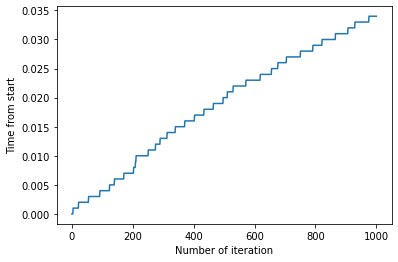

In [6]:
Xf = gd(grad, [-3, 3], timing = True) #returning x,y,t for each iteration
plt.plot(Xf[:,2])
plt.xlabel("Number of iteration")
plt.ylabel("Time from start")
plt.show()

Here we define a function returning the results needed for various functions.  Basically a wrapper for the previous minimization approaches. The function computes the "minimization path" for each starting point in the initial 15x15 grid and returns the mean value for the "energy" at each iteration. The function also returns the total running time divided by the number of epochs. We plot these values for each method for different learning rates.

In [7]:
def minResults(x,y,eta,epochs,minfunc, func, grad):
    Results = pd.DataFrame()
    count = 0
    start = time.time()
    for i in tqdm(x, leave = False):
        count += 1
        #print(count)
        for j in tqdm(y, leave = False): 
            Results[str(i) + " " + str(j)] = func(minfunc(grad, np.array([i,j]), eta = eta, n_epochs = epochs).T)
    end = time.time()
    return Results.mean(axis = 1), (end-start)/epochs

In [8]:
eta = [0.01, 0.001, 0.0001] #we try different learning rates (NOTE: for eta = 0.1 the gd, gd_with_mom and NAG diverge)

NOTE: the process of minimization for all points of the grid takes some time. In order to visualize the process we used loading bars from package tqdm. These bars may not be displayed correctly opening the notebook without running the cells. 

In [ ]:
Results_gd = pd.DataFrame()
for e in eta:
    print('Minimizing with eta = ' , e)
    Results_gd['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 5000, gd, func, grad)
    Results_gd['eta = ' + str(e) + '_time'] = np.arange(5001)*time_per_iteration/225
    print('done!\n')
    

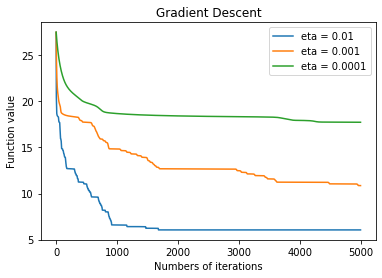

In [10]:
Results_gd.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.title("Gradient Descent")
plt.show()
#Results_gd

In [ ]:
Results_gd_mom = pd.DataFrame()
for e in eta:
    print('Minimizing with eta = ' , e)
    Results_gd_mom['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 5000, gd_with_mom, func, grad)
    Results_gd_mom['eta = ' + str(e) + '_time'] = np.arange(5001)*time_per_iteration/225
    print('done!\n')

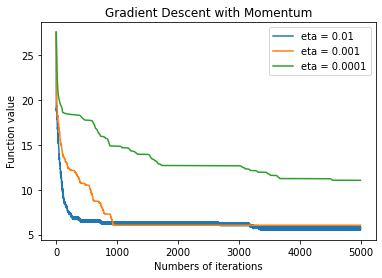

In [12]:
Results_gd_mom.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.title("Gradient Descent with Momentum")
plt.show()
# Results_gd_mom

In [ ]:
Results_NAG = pd.DataFrame()
for e in eta:
    print('Minimizing with eta = ' , e)
    Results_NAG['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 5000, NAG, func, grad)
    Results_NAG['eta = ' + str(e) + '_time'] = np.arange(5001)*time_per_iteration/225
    print('done!\n')

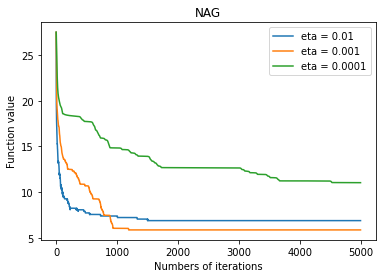

In [14]:
Results_NAG.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.title("NAG")

plt.show()
# Results_NAG

In [15]:
eta = [0.1, 0.01, 0.001, 0.0001] #we try different learning rates

In [ ]:
Results_rms = pd.DataFrame()
for e in eta:
    print('Minimizing with eta = ' , e)
    Results_rms['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 5000, rms_prop, func, grad)
    Results_rms['eta = ' + str(e) + '_time'] = np.arange(5001)*time_per_iteration/225
    print('done!\n')

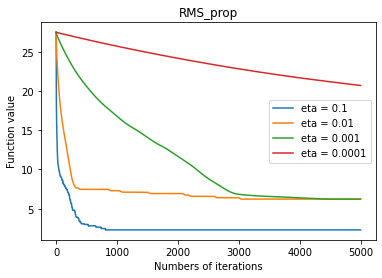

In [17]:
%matplotlib inline
Results_rms.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.title("RMS_prop")
plt.show()
# Results_rms

In [ ]:
Results_adams = pd.DataFrame()
for e in eta:
    print('Minimizing with eta = ' , e)
    Results_adams['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 5000, adams, func, grad)
    Results_adams['eta = ' + str(e) + '_time'] = np.arange(5001)*time_per_iteration/225
    print('done!\n')

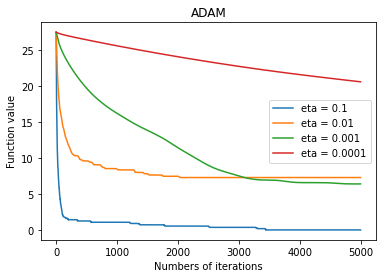

In [19]:
%matplotlib inline
Results_adams.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.title("ADAM")
plt.show()
# Results_adams

The best $\eta$ for every algotithm are choosen as the one for which the global trend is a fast and stable convergence: 

GD: 0.01

GD_mom: 0.001

NAG: 0.001

RMS_prop: 0.1

ADAM: 0.1

Now we plot the best results for every algorithm with the actual CPU time used. As before the iteration time is assumed to be fairly constant, and then a good estimation can be found by dividing the total computation time for the 15x15 by the number of points and the number of epochs. This value is then multiplied by the iteration number and associated to the correspondent average function value to get the next plot.

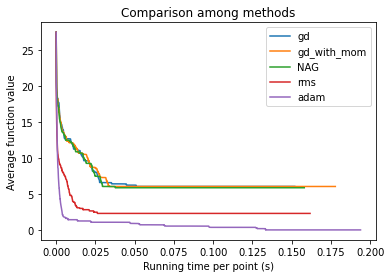

In [20]:
%matplotlib inline
plt.plot(Results_gd["eta = 0.01_time"], Results_gd["eta = 0.01"], label = "gd")
plt.plot(Results_gd_mom["eta = 0.001_time"], Results_gd_mom["eta = 0.001"], label = "gd_with_mom")
plt.plot(Results_NAG["eta = 0.001_time"], Results_NAG["eta = 0.001"], label = "NAG")
plt.plot(Results_rms["eta = 0.1_time"], Results_rms["eta = 0.1"], label = "rms")
plt.plot(Results_adams["eta = 0.1_time"], Results_adams["eta = 0.1"], label = "adam")
plt.ylabel("Average function value")
plt.xlabel("Running time per point (s)")

plt.title("Comparison among methods")
plt.legend()
plt.show()

The first three algorithms show a similar behaviour on average and for some points they do not reach the global minimum as we can see from the non zero final mean. RMS-prop and ADAM show a better results, in particular ADAM seems to manage to reach the minimum for almost each starting point. Concerning running times ADAM and RMS-prop seems to reach convergence faster than other methods

### Comparison GD, Adam, RMS_prop: 

Now we plot the minimization path for three specific point in order to compare the three algorithms.
We can notice that the GD algorithm seems faster on the first steps as it follows the steep descent. 
On the other hand, the Adam and RMS-prop algorithms typically have the same path. We outlined a point (-3, -2) for which only ADAM does converge at the global minimum.

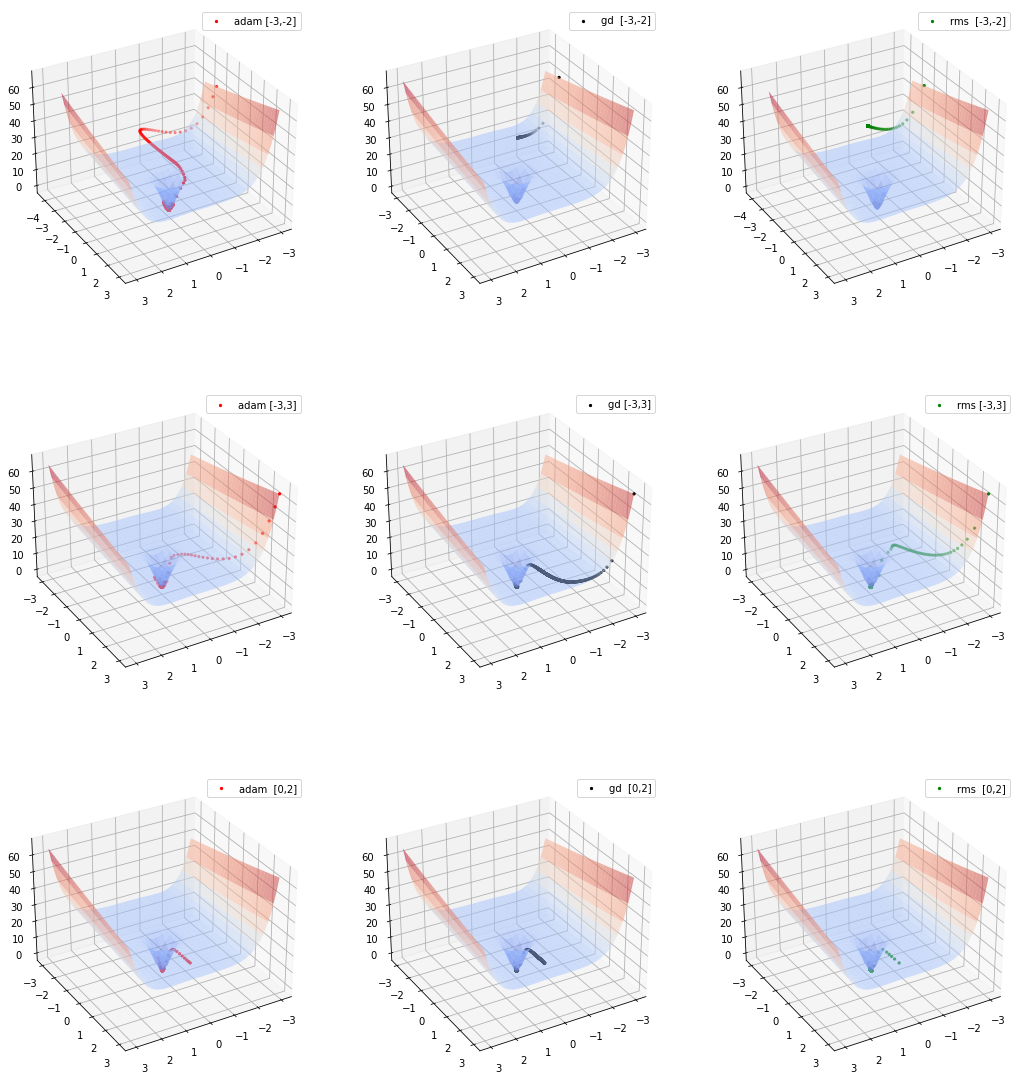

In [21]:
%matplotlib inline
xplot = np.linspace(-3, 3, 60)
yplot = np.linspace(-3, 3, 60)


Xplot = np.meshgrid(xplot,yplot)
fig  = plt.figure(figsize=(18,20))

ax = fig.add_subplot(3, 3, 1, projection='3d')
ax2= fig.add_subplot(3,3,2, projection = '3d')
ax3= fig.add_subplot(3,3,3, projection = '3d')

ax4 = fig.add_subplot(3, 3, 4, projection='3d')
ax5= fig.add_subplot(3,3,5, projection = '3d')
ax6= fig.add_subplot(3,3,6, projection = '3d')


ax7= fig.add_subplot(3, 3,7, projection='3d')
ax8= fig.add_subplot(3,3,8, projection = '3d')
ax9= fig.add_subplot(3,3,9, projection = '3d')


ax.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax.view_init(30,60)
ax2.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax2.view_init(30,60)
ax3.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax3.view_init(30,60)
ax4.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax4.view_init(30,60)
ax5.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax5.view_init(30,60)
ax6.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax6.view_init(30,60)
ax7.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax7.view_init(30,60)
ax8.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax8.view_init(30,60)
ax9.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax9.view_init(30,60)


P1_adam = adams(grad, [-3,-2], n_epochs=50000, eta=0.1, noise_strength=0,)
ax.scatter(P1_adam[:,0], P1_adam[:,1], func(P1_adam.T), marker = '.', color = 'red', linewidth =  1, label = "adam [-3,-2]")
P1_gd = gd(grad, [-3,-2], n_epochs=50000, eta=0.01, noise_strength=0,)
ax2.scatter(P1_gd[:,0], P1_gd[:,1], func(P1_gd.T), marker = '.', color = 'black', linewidth =  1, label = "gd  [-3,-2]")
P1_rms = rms_prop(grad, [-3,-2], n_epochs=50000, eta=0.1, noise_strength=0,)
ax3.scatter(P1_rms[:,0], P1_rms[:,1], func(P1_rms.T), marker = '.', color = 'green', linewidth =  1, label = "rms  [-3,-2]")


P2_adam = adams(grad, [-3,3], n_epochs=50000, eta=0.1, noise_strength=0,)
ax4.scatter(P2_adam[:,0], P2_adam[:,1], func(P2_adam.T), marker = '.', color = 'red', linewidth =  1, label = "adam [-3,3]")
P2_gd = gd(grad, [-3,3], n_epochs=50000, eta=0.01, noise_strength=0,)
ax5.scatter(P2_gd[:,0], P2_gd[:,1], func(P2_gd.T), marker = '.', color = 'black', linewidth =  1, label = "gd [-3,3]")
P2_rms = rms_prop(grad, [-3,3], n_epochs=50000, eta=0.1, noise_strength=0,)
ax6.scatter(P2_rms[:,0], P2_rms[:,1], func(P2_rms.T), marker = '.', color = 'green', linewidth =  1, label = "rms [-3,3]")

P3_adam = adams(grad, [0,2], n_epochs=50000, eta=0.1, noise_strength=0,)
ax7.scatter(P3_adam[:,0], P3_adam[:,1], func(P3_adam.T), marker = '.', color = 'red', linewidth =  1, label = "adam  [0,2]")
P3_gd = gd(grad, [0,2], n_epochs=50000, eta=0.01, noise_strength=0,)
ax8.scatter(P3_gd[:,0], P3_gd[:,1], func(P3_gd.T), marker = '.', color = 'black', linewidth =  1, label = "gd  [0,2]")
P3_rms = rms_prop(grad, [0,2], n_epochs=50000, eta=0.1, noise_strength=0,)
ax9.scatter(P3_rms[:,0], P3_rms[:,1], func(P3_rms.T), marker = '.', color = 'green', linewidth =  1, label = "rms  [0,2]")


ax.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax7.legend()
ax8.legend()
ax9.legend()

plt.show()

It is interesting to notice that ADAM algorithm, once reached the minimum, seems to bounce back and oscillate in the proximity. Now let us visualize the cost function bound to each minimization path.

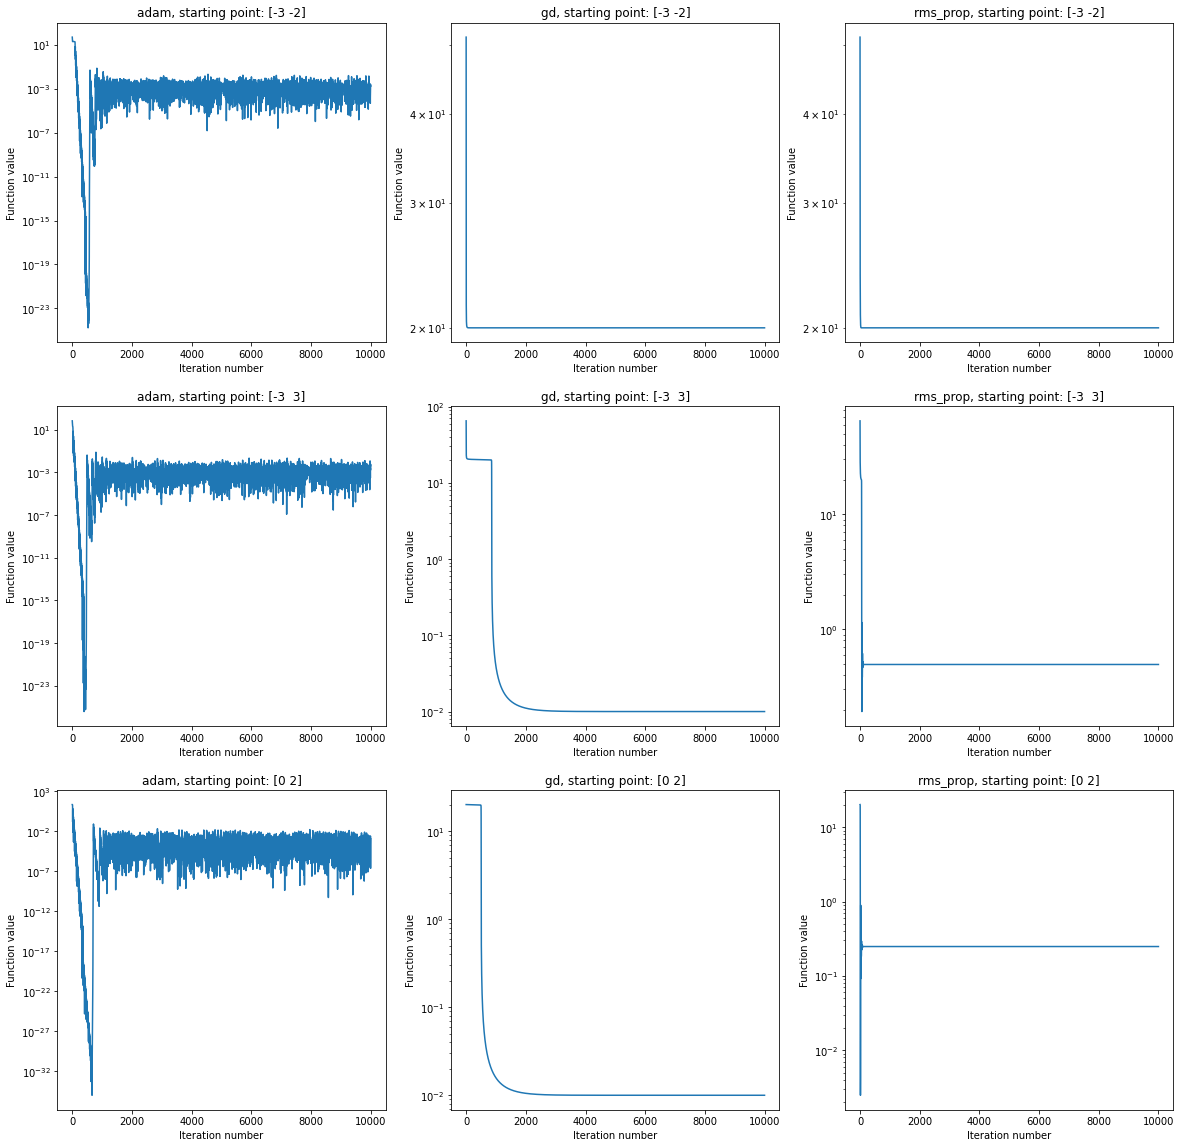

In [16]:
fig, ax = plt.subplots(3,3, figsize = (20,20))

pts_array = np.array([[-3,-2], [-3, -2], [-3, -2], [-3, 3], [-3, 3], [-3, 3], [0, 2], [0, 2], [0,2]])
epochs = 10000
methods = [adams, gd, rms_prop]
method = ["adam", "gd", "rms_prop"]
eta2 = [0.1, 0.01, 0.1]
for i in range(3):
    for j in range(3):
        ax[i,j].plot(np.arange(epochs+1), func(methods[j](grad, pts_array[3*i+j], n_epochs = epochs, eta=eta2[j]).T))
        ax[i,j].set_title(method[j] + ", starting point: "+ str( pts_array[3*i+j]))
        ax[i,j].set_xlabel("Iteration number")
        ax[i,j].set_ylabel("Function value")
        ax[i,j].set_yscale('log')
plt.show()

As we saw before ADAM is in general a better method: the function value after some iterations is close to the global minimum, while RMS-prop and gd sometimes do not manage to converge. The main downside of ADAM is that after having reached the minimum it starts pushing the function away from it and continuosly move, with an unstable behaviour; anyway it never bounces out of the global minimum, so for this function we can choose it as the best method.

# Ex 2

Now we study the behaviour of ADAM algorithm for a "energy" function that present a global minimum but also a lot of local minima, in which the algorithm could wrongly stop.

In [23]:
def func_2(X, q = 6):
    return 1 + 0.5*q* (X[0]**2+X[1]**2) - np.cos(2*np.pi*(X[0]*X[1]-X[1]**2))

def gradx_2(X,q = 6):
    return q*X[0] + 2*np.pi*X[1]*np.sin(2*np.pi*(X[0]*X[1]-X[1]**2))

def grady_2(X, q = 0.1):
    return q*X[1]+ 2*np.pi*(X[0]-2*X[1])*np.sin(2*np.pi*(X[0]*X[1]-X[1]**2))

def grad_2(X):
    return [gradx_2(X), grady_2(X)]

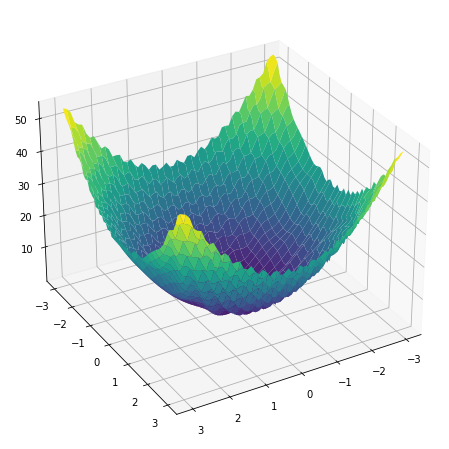

In [24]:
%matplotlib inline
xplot = np.linspace(-3, 3, 60)
yplot = np.linspace(-3, 3, 60)


Xplot = np.meshgrid(xplot,yplot)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection = '3d')


ax.plot_surface(Xplot[0], Xplot[1], func_2(Xplot), cmap = 'viridis')
ax.view_init(30,60)
plt.show()

Also in this case we plot the trend of the cost function for some initial point.

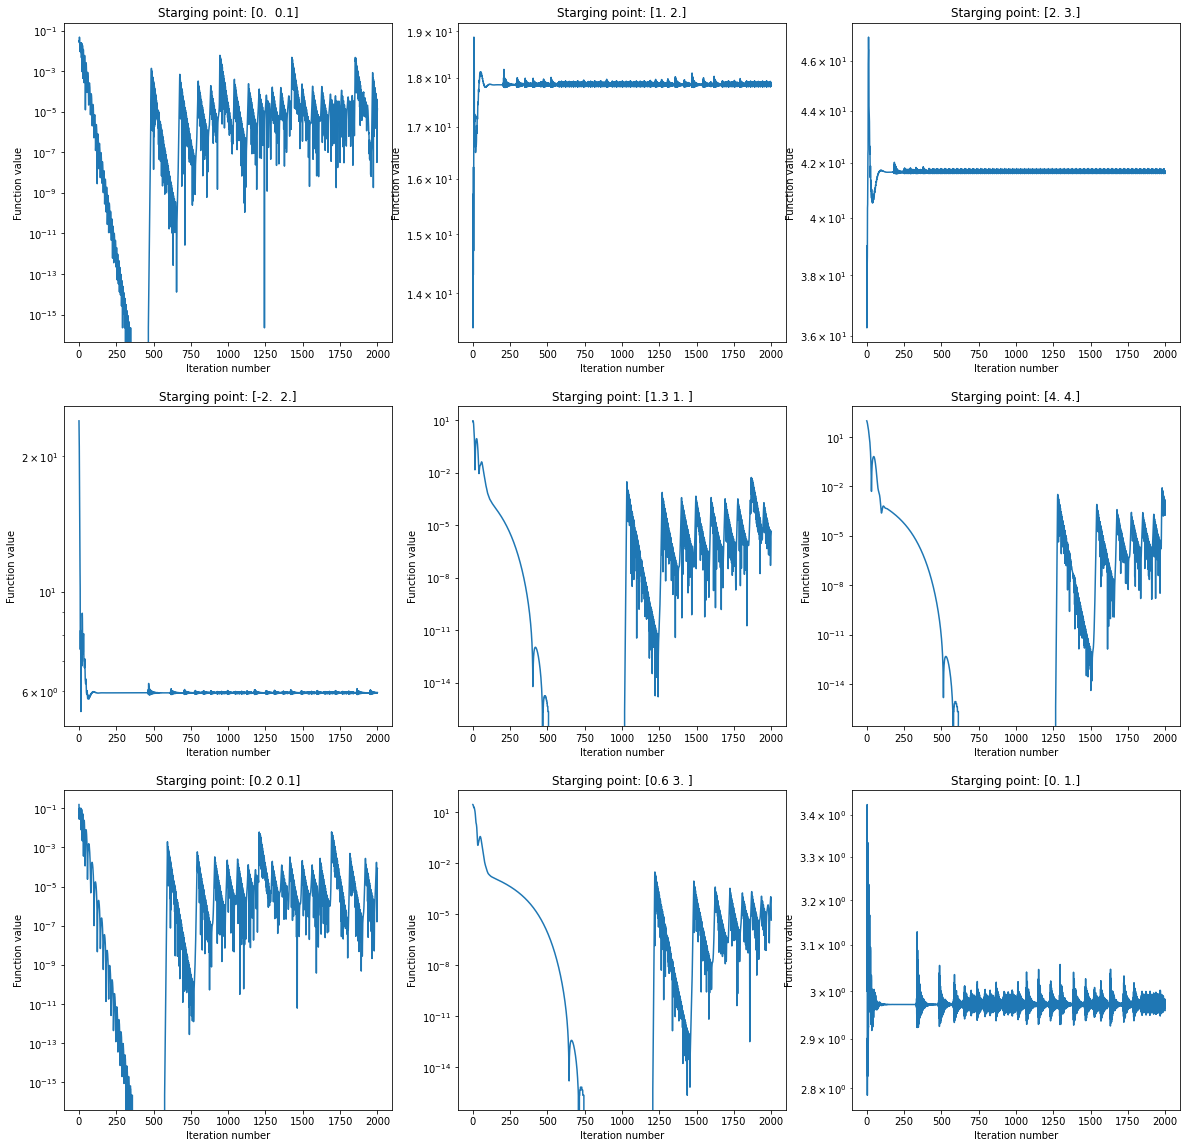

In [25]:
fig, ax = plt.subplots(3,3, figsize = (20,20))

pts_array = np.array([[0.,0.1], [1,2], [2,3], [-2,2], [1.3, 1], [4,4], [0.2, 0.1], [0.6, 3], [0,1]])
epochs = 2000
for i in range(3):
    for j in range(3):
        
        ax[i,j].plot(np.arange(epochs+1), func_2(adams(grad_2, pts_array[3*i+j], n_epochs = epochs,eta = 0.1).T) )
        ax[i,j].set_title("Starging point: "+ str( pts_array[3*i+j]))
        ax[i,j].set_xlabel("Iteration number")
        ax[i,j].set_ylabel("Function value")
        ax[i,j].set_yscale('log')

plt.show()

As shown in the previous cases, the ADAM algorithm does not manage to converge in all cases. 
In the last one, in particular, it keeps bouncing between some points into the same local minima. In some cases the minimization path stops in a local minimum (as in (2, -2)).
In many cases, as for the starting points ((0, 0.1), (1.3,1), (4,4), (0.2,0.1)...), the function reach the global minimum and bounces away reaching higher values.

Clearly this algorithm, for the second function tried, is less reliable due to the presence of many local minima.

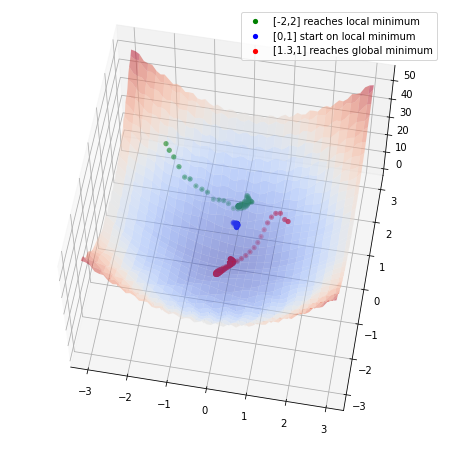

In [26]:
%matplotlib inline
xplot = np.linspace(-3, 3, 60)
yplot = np.linspace(-3, 3, 60)


Xplot = np.meshgrid(xplot,yplot)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection = '3d')


ax.plot_surface(Xplot[0], Xplot[1], func_2(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax.view_init(60,280)

P1 = adams(grad_2, [-2,2], n_epochs=250, eta=0.1, noise_strength=0,)
ax.scatter(P1[:,0], P1[:,1], func_2(P1.T), marker = '.', color = 'green', linewidth = 3, label = "[-2,2] reaches local minimum")

P2 = adams(grad_2, [0,1], n_epochs=2000, eta=0.1, noise_strength=0,) #local minimum
ax.scatter(P2[:,0], P2[:,1], func_2(P2.T), marker = '.', color = 'blue', linewidth = 3, label = "[0,1] start on local minimum")

P3 = adams(grad_2, [1.3,1], n_epochs=20000, eta=0.1, noise_strength=0,)
ax.scatter(P3[:,0], P3[:,1], func_2(P3.T), marker = '.', color = 'red', linewidth = 3, label = "[1.3,1] reaches global minimum")

#An other point that do not converge in the global minimum
#P4 = adams(grad_2, [-1.3,1], n_epochs=250, eta=0.1, noise_strength=0,)
#ax.scatter(P4[:,0], P4[:,1], func_2(P4.T), marker = '.', color = 'green', linewidth = 3, label = "[-1.3,1]")

#NAG instead converge
#P_NAG = NAG(grad_2, [-1.3,1], n_epochs=250, eta=0.01, noise_strength=0,)
#ax.scatter(P_NAG[:,0], P_NAG[:,1], func_2(P_NAG.T), marker = '.', color = 'blue', linewidth = 3, label = "NAG : [-1.3,1]")

ax.legend()
plt.show()